In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [9]:
import tensorflow as tf 
import os

In [10]:
def load_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

def load_dataset(directory, target_size=(256, 256)):
    high_light_dir = os.path.join(directory, 'high')
    low_light_dir = os.path.join(directory, 'low')
    
    high_light_images = [os.path.join(high_light_dir, img) for img in os.listdir(high_light_dir)]
    low_light_images = [os.path.join(low_light_dir, img) for img in os.listdir(low_light_dir)]
    
    high_light_dataset = tf.data.Dataset.from_tensor_slices(high_light_images)
    low_light_dataset = tf.data.Dataset.from_tensor_slices(low_light_images)
    
    high_light_dataset = high_light_dataset.map(lambda x: load_image(x, target_size))
    low_light_dataset = low_light_dataset.map(lambda x: load_image(x, target_size))
    
    return high_light_dataset, low_light_dataset

In [11]:
train_dir = '/kaggle/input/lol-dataset/lol_dataset/our485'
val_dir = '/kaggle/input/lol-dataset/lol_dataset/eval15'

train_high_light_dataset, train_low_light_dataset = load_dataset(train_dir)
val_high_light_dataset, val_low_light_dataset = load_dataset(val_dir)

# Combine high and low light datasets
train_dataset = tf.data.Dataset.zip((train_low_light_dataset, train_high_light_dataset))
val_dataset = tf.data.Dataset.zip((val_low_light_dataset, val_high_light_dataset))

# Optional: Shuffle and batch the datasets
batch_size = 4

train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [12]:
print(len(train_dataset))
print(len(val_dataset))

122
4


In [14]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Input, BatchNormalization,Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def generator_F(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Downsample
    d1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)  # 64x64x64
    d1 = LeakyReLU(alpha=0.2)(d1)
    
    d2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(d1)  # 32x32x128
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)
    
    d3 = Conv2D(256, kernel_size=4, strides=2, padding='same')(d2)  # 16x16x256
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    
    d4 = Conv2D(512, kernel_size=4, strides=2, padding='same')(d3)  # 8x8x512
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)
    
    d5 = Conv2D(512, kernel_size=4, strides=2, padding='same')(d4)  # 4x4x512
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU(alpha=0.2)(d5)
    
    
    # Bottleneck
    bottleneck = Conv2D(512, kernel_size=4, strides=1, padding='same')(d5)  # 4x4x512
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = LeakyReLU(alpha=0.2)(bottleneck)
    
    # Upsample
    u0 = Conv2DTranspose(512, kernel_size=4, strides=1, padding='same')(bottleneck)  # 4x4x512
    u0 = BatchNormalization()(u0)
    u0 = Activation('relu')(u0)
    u0 = Concatenate()([u0, d5])
    
    u1 = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(u0)  # 8x8x512
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Concatenate()([u1, d4])
    
    u2 = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(u1)  # 16x16x512
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Concatenate()([u2, d3])
    
    u3 = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(u2)  # 32x32x256
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Concatenate()([u3, d2])
    
    u4 = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(u3)  # 64x64x128
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Concatenate()([u4, d1])
    
    u5 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(u4)  # 128x128x64
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(u5)  # 128x128x3
    
    return Model(inputs, outputs)

F = generator_F()
F.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_20[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_21[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_22      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_22[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 36,265,795 (138.34 MB)

 Trainable params: 36,257,987 (138.31 MB)

 Non-trainable params: 7,808 (30.50 KB)

**Generator G **

In [17]:
def generator_G(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Downsample
    d1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)  # 64x64x64
    d1 = LeakyReLU(alpha=0.2)(d1)
    
    d2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(d1)  # 32x32x128
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)
    
    d3 = Conv2D(256, kernel_size=4, strides=2, padding='same')(d2)  # 16x16x256
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    
    d4 = Conv2D(512, kernel_size=4, strides=2, padding='same')(d3)  # 8x8x512
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)
    
    d5 = Conv2D(512, kernel_size=4, strides=2, padding='same')(d4)  # 4x4x512
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU(alpha=0.2)(d5)
    
    
    # Bottleneck
    bottleneck = Conv2D(512, kernel_size=4, strides=1, padding='same')(d5)  # 4x4x512
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = LeakyReLU(alpha=0.2)(bottleneck)
    
    # Upsample
    u0 = Conv2DTranspose(512, kernel_size=4, strides=1, padding='same')(bottleneck)  # 4x4x512
    u0 = BatchNormalization()(u0)
    u0 = Activation('relu')(u0)
    u0 = Concatenate()([u0, d5])
    
    u1 = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(u0)  # 8x8x512
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Concatenate()([u1, d4])
    
    u2 = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(u1)  # 16x16x512
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Concatenate()([u2, d3])
    
    u3 = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(u2)  # 32x32x256
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Concatenate()([u3, d2])
    
    u4 = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(u3)  # 64x64x128
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Concatenate()([u4, d1])
    
    u5 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(u4)  # 128x128x64
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(u5)  # 128x128x3
    
    return Model(inputs, outputs)

G = generator_G()
G.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 128, 128,  │          0 │ conv2d_34[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_34[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_35[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_36[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 36,265,795 (138.34 MB)

 Trainable params: 36,257,987 (138.31 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [ ]:
from keras.utils import plot_model
plot_model(G,show_shapes = True, show_layer_names = True, to_file='Generator_Model(G).png')

In [21]:
from tensorflow.keras.activations import sigmoid

def discriminator_D_Y(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    
    outputs = Dense(1,activation='linear')(x)
    
    
    return Model(inputs, outputs)

D_Y = discriminator_D_Y()
D_Y.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,617 (11.02 MB)

 Trainable params: 2,887,617 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def discriminator_D_X(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    
    outputs = Dense(1,activation='linear')(x)
    
    
    return Model(inputs, outputs)

D_X = discriminator_D_X()
D_X.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_59 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,617 (11.02 MB)

 Trainable params: 2,887,617 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.utils import plot_model
plot_model(D_X,show_shapes = True, show_layer_names = True, to_file='Discriminator_Model(D_X).png')

In [34]:
"""import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix"""

'import tensorflow_datasets as tfds\nfrom tensorflow_examples.models.pix2pix import pix2pix'

In [35]:
"""OUTPUT_CHANNELS = 3

G= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
F = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

D_X = pix2pix.discriminator(norm_type='instancenorm', target=False)
D_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)"""

"OUTPUT_CHANNELS = 3\n\nG= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')\nF = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')\n\nD_X = pix2pix.discriminator(norm_type='instancenorm', target=False)\nD_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)"

In [36]:
from tensorflow.keras.optimizers import Adam

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity):
    return lambda_identity * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [50]:
# Optimizers
generator_g_optimizer = Adam(0.00015,beta_1=0.4)
generator_f_optimizer = Adam(2e-4,beta_1=0.9)
discriminator_x_optimizer = Adam(2e-3,beta_1=0.4)
discriminator_y_optimizer = Adam(1e-3,beta_1=0.3)

In [51]:
# Training step function
gen_g_losses=[]
gen_f_losses=[]
disc_x_losses=[]
disc_y_losses=[]

@tf.function
def train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle, lambda_identity):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X to Y
        fake_y = G(real_x, training=True)
        # Generator F translates Y to X
        fake_x = F(real_y, training=True)

        # Cycle consistency
        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity mapping
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator output
        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Calculate the losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        cycle_loss_g = cycle_consistency_loss(real_x, cycled_x, lambda_cycle)
        cycle_loss_f = cycle_consistency_loss(real_y, cycled_y, lambda_cycle)

        identity_loss_g = identity_loss(real_y, same_y, lambda_identity)
        identity_loss_f = identity_loss(real_x, same_x, lambda_identity)

        total_gen_g_loss = gen_g_loss + cycle_loss_g + identity_loss_g
        total_gen_f_loss = gen_f_loss + cycle_loss_f + identity_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients
    gradients_of_generator_g = tape.gradient(total_gen_g_loss, G.trainable_variables)
    gradients_of_generator_f = tape.gradient(total_gen_f_loss, F.trainable_variables)

    gradients_of_discriminator_x = tape.gradient(disc_x_loss, D_X.trainable_variables)
    gradients_of_discriminator_y = tape.gradient(disc_y_loss, D_Y.trainable_variables)

    # Apply the gradients to the optimizers
    generator_g_optimizer.apply_gradients(zip(gradients_of_generator_g, G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_of_generator_f, F.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(gradients_of_discriminator_x, D_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_of_discriminator_y, D_Y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [52]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [53]:
val_high_images=list(val_high_light_dataset.as_numpy_iterator())
val_low_images=list(val_low_light_dataset.as_numpy_iterator())

example_real_x=val_low_images[0]
example_real_y=val_high_images[0]

In [54]:
def denormalize_image(image):
    """Convert an image from [-1, 1] to [0, 1] for visualization."""
    return (image + 1.0) / 2.0

def plot_generated_images(generator,input_image,title):
    generated_image=generator(tf.expand_dims(input_image,0),training=False)[0]
    
    input_image=denormalize_image(input_image)
    generated_image=denormalize_image(generated_image)
    
    plt.imshow(np.hstack([input_image,generated_image]))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [55]:
def loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch):
    plt.figure(figsize=(10,5))
    plt.plot(gen_g_losses,label='Generator G Loss')
    plt.plot(gen_f_losses,label='Generator F Loss')
    plt.plot(disc_x_losses,label='Discriminator X Loss')
    plt.plot(disc_y_losses,label='Discriminator Y Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)
    
    plt.show()

Epoch 20/20
Generator G Loss: 3024.36083984375, Generator F Loss: 4.428704261779785
Discriminator X Loss: 664.9227294921875, Discriminator Y Loss: 438.5256042480469


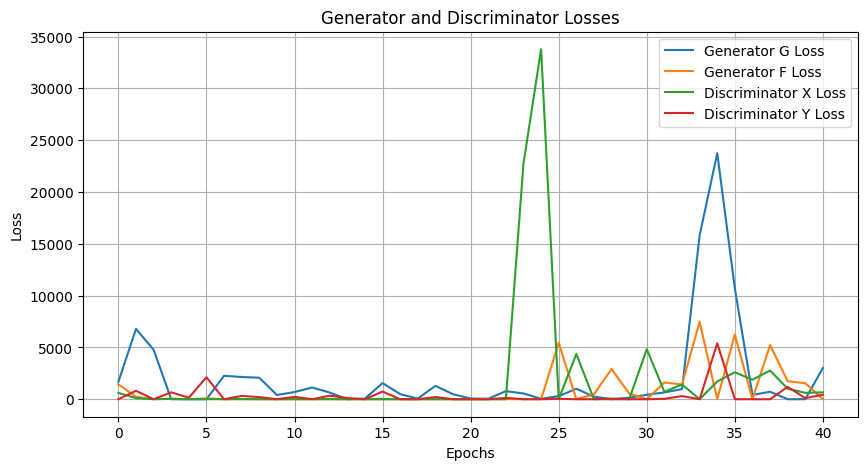

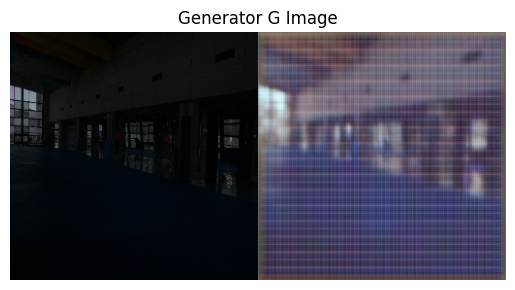

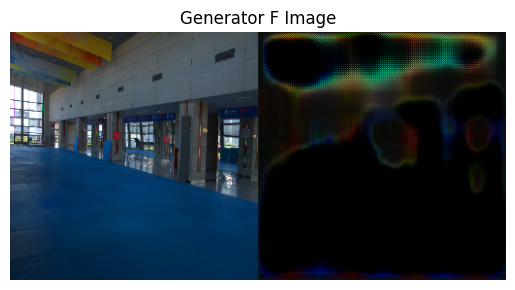

In [60]:
epochs = 20
lambda_cycle = 10.0
lambda_identity = 0.5


for epoch in range(epochs):
    clear_output(wait=True)
    
    for real_x, real_y in train_dataset:
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle=10.0, lambda_identity=0.5)
    
    gen_g_losses.append(total_gen_g_loss.numpy())
    gen_f_losses.append(total_gen_f_loss.numpy())
    disc_x_losses.append(disc_x_loss.numpy())
    disc_y_losses.append(disc_y_loss.numpy())
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Generator G Loss: {total_gen_g_loss}, Generator F Loss: {total_gen_f_loss}')
    print(f'Discriminator X Loss: {disc_x_loss}, Discriminator Y Loss: {disc_y_loss}')
    
    loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch)
    
    plot_generated_images(G,example_real_x,'Generator G Image')
    plot_generated_images(F,example_real_y,'Generator F Image')

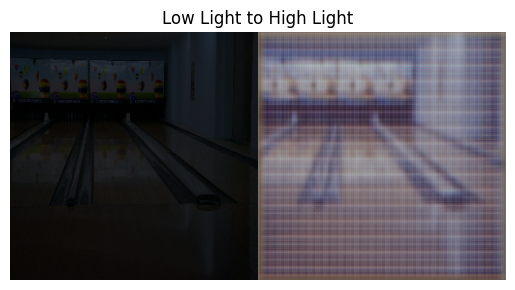

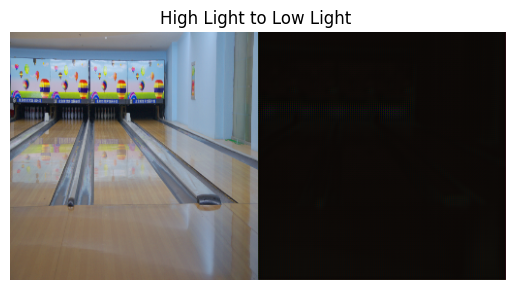

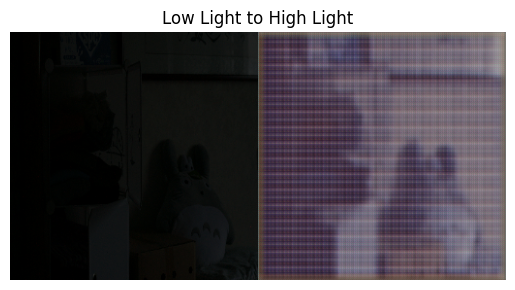

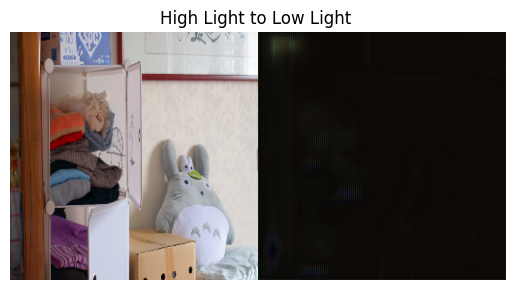

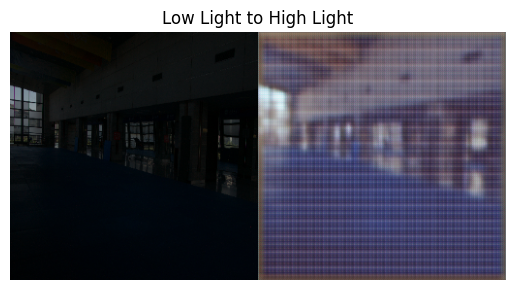

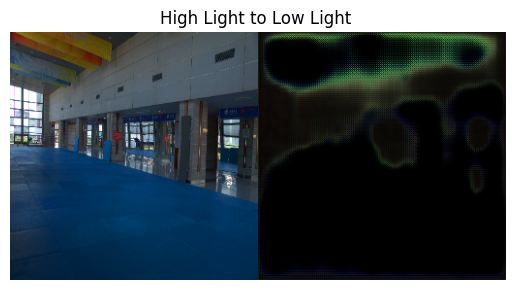

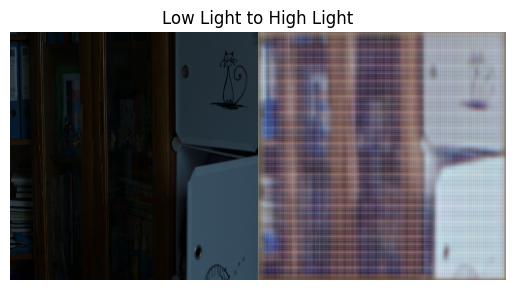

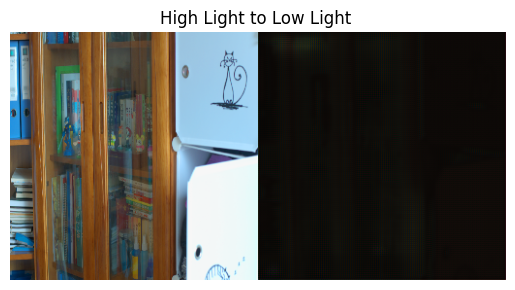

In [61]:
from random import randint
for i in range(0,4):
    
    l=randint(0,14)
    
    example_real_x=val_low_images[l]
    example_real_y=val_high_images[l]

    plot_generated_images(G,example_real_x,'Low Light to High Light')
    plot_generated_images(F,example_real_y,'High Light to Low Light ')

In [63]:
# Assuming generator and discriminator are your model instances

# Save weights
G.save_weights('generator.weights.h5')
D_X.save_weights('discriminator.weights.h5')
